# Data Mining in Action, Deep Leaning

## Семантическая сегментация

В этом задании мы будем практиковаться в семантической сегментации. Реализуем популярную сеть для решения задачи семантической сегментации U-net, обучим её на синтетическом датасете с фигурами, оценим качество модели.

В рамках задания нужно получить ответы на вопросы в этом ipynb блокноте и внести их в [гугл-форму](https://forms.gle/mVUGJQRVSSHDsveG7). Перед тем как приступать к выполнению задания не забудьте выполнить команду ```pip install -r <path_to_rep_requirements.txt>``` для того, чтобы в вашем виртуальном окружении были установлены правильные версии python пакетов.

In [1]:
%pylab inline

import torch
import torchvision
from torch.utils.data import Dataset
from PIL import ImageDraw, Image

Populating the interactive namespace from numpy and matplotlib


Для создания моделей-сетей в `pytorch` удобно создавать класс, наследуясь от `torch.nn.Module`. В `torch.nn` содержася стандартные "кирпичики" для моделей (например, различные виды слоёв). В `torch.optim` содержатся оптимизаторы, а в `torch.utils.data` много необходимых сущеностей для работы с данными.

### Построение сети

Начнём с построения сети. Для сегментации будем использовать архитекрутуру U-net.

![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Архитектура состоит из блоков (горизонтальные участки из синих прямоугольников). На примере выше сначала идёт 5 блоков кодировщика, далее 4 блока декодировщика. Между блоками кодировщика происходит уменьшение размерности в 2 раза с помощью max pooling. В декодировщике применяется upsampling и конкатенация с результатами соответствующего блока кодировщика. 

Давайте реализуем U-net по частям. Начнём с кодировщика. 

Один блок кодировщика состоит из двух последовательных сверток, активаций и батчнорма (опционально, но мы его сделаем дефолтным):

In [2]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [3]:
block = EncoderBlock(3, 16)
block

EncoderBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
)

Запустим на картинке с 3 каналами размера 200 на 200 (первая "единичка" означает число картинок в батче).

In [4]:
block(torch.rand((1, 3, 200, 200))).size()

torch.Size([1, 16, 200, 200])

Получается, что размерность выхода при применении блока кодировщика не изменяется. Изменяется она только на max pooling и upsampling слоях.

Теперь составим кодировщик из описанных выше блоков. Конструкция определяется входными каналами, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации. Здесь как раз помогает подход к построению через `add_module`, так как количество блоков переменно.

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if i == 0 else out_channels
            out_channels = num_filters if i == 0 else in_channels * 2
            self.add_module('block_{}'.format(i + 1), EncoderBlock(in_channels, out_channels))
            # add also torch.nn.MaxPool2d(2, 2)) but not every time
            if i < num_blocks - 1:
                self.add_module('maxpool_{}'.format(i + 1), torch.nn.MaxPool2d(2, 2))
            
    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            block = self.__getattr__('block_{}'.format(i + 1))
            # apply
            activation = block(x)
            # pooling
            if i < self.num_blocks - 1:
                maxpool = self.__getattr__('maxpool_{}'.format(i + 1))
                x = maxpool(activation)
            # saving activations
            activations.append(activation)
        # your code
        return activations

Создадим кодировщик из 4 блоков, где базовая размерность будет 8.

In [6]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block_1): EncoderBlock(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block_2): EncoderBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

Проверьте, что на изображении 256 на 256 после каждого блока кодировщика размерность уменьшается в 2 раза, а число фильтров увеличивается в 2 раза, начиная с 8.

In [7]:
batch_X = torch.zeros(4, 3, 256, 256)

for x in encoder(batch_X):
    print(x.shape)

torch.Size([4, 8, 256, 256])
torch.Size([4, 16, 128, 128])
torch.Size([4, 32, 64, 64])
torch.Size([4, 64, 32, 32])


**Вопрос 1: Размерность последнего слоя энкодера**

Какая размерность на последнем слое (перемножьте все размерности включая размер батча). Внесите свой ответ в поле _"Вопрос 1: Размерность последнего слоя энкодера"_ гугл-формы этого домашнего задания.

In [8]:
4 * 64 * 32 * 32

262144

Блок декодировщика состоит из апскейлинга входа "снизу", объединения двух входов и сверток как в кодировщике. Перед конкатенированием используем свёртку для уменьшения числа фильтров в 2 раза (их количество и так растёт в 2 раза в результате объединения).

In [9]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(out_channels * 2, out_channels, 3, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels * 2, out_channels, 3, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.relu3 = torch.nn.ReLU()

    def forward(self, down, left):
        # upscale->conv+relu->concat->conv+relu->conv+relu - make it
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        # your code
        x = self.conv1(x)
        x = self.relu1(x)
        x = torch.cat((left, x), dim=1)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        return x

Проверим блок декодера, который отдаёт на выходе картинку толщиной в 8 фильтров.

In [10]:
block = DecoderBlock(8)

In [11]:
batch_inside = encoder(batch_X)
batch_inside[1].shape, batch_inside[0].shape

(torch.Size([4, 16, 128, 128]), torch.Size([4, 8, 256, 256]))

In [12]:
block(batch_inside[1], batch_inside[0]).shape

torch.Size([4, 8, 256, 256])

Декодировщик собираем из таких блоков:

In [13]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        for i in range(num_blocks):
            self.add_module('block_{}'.format(num_blocks - i), DecoderBlock(num_filters * 2**i))

    def forward(self, activations):
        # your code
        x = activations[-1]
        for i in range(self.num_blocks):
            block = self.__getattr__('block_{}'.format(i + 1))
            x = block(x, activations[-(i+2)])
        return x

In [14]:
decoder = Decoder(8, 3)

In [15]:
print(batch_X.shape)
print(decoder(encoder(batch_X)).shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 8, 256, 256])


U-Net состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [16]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=8, num_blocks=4):
        super().__init__()
        self.encoder =  Encoder(in_channels=in_channels, num_filters=num_filters, num_blocks=num_blocks)
        self.decoder =  Decoder(num_filters=num_filters, num_blocks=num_blocks - 1)
        self.final =  torch.nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [17]:
model = UNet(num_classes=6)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)
model(images).shape

torch.Size([4, 6, 416, 416])

**Вопрос 2: Размерность на выходе всей модели** 

Какая размерность получилась на выходе (перемножьте все размерности, включая количество батчей)? Внесите свой ответ в поле _"Вопрос 2:  Размерность на выходе всей модели"_ гугл-формы этого домашнего задания.

In [19]:
4 * 6 * 416 * 416

4153344

На выходе из сети получаем бинарную маску из линейных активаций. Для обучения такой модели используются функции потерь, которые включают в себя применение активации. В вероятности их можно превращать с помощью `torch.sigmoid`.

### Данные

Будем решать задачу семантической сегментации на синтетических данных, представляющий собой множество эллипсов, квадратов и треугольников с гауссовым шумом.

Для загрузки данных pytorch опирается на такую сущность, как `Dataset`. Этот абстрактный класс определен в `torch.utils.data.dataset`.

In [20]:
class Figures(Dataset):
    def __init__(self, num_images=10, num_figure=10, size_hor=200, size_ver=200,
                 min_size=5, max_size=40, noise=False,
                 normalize=None):
        
        self.images = []
        
        for _ in range(num_images):
            color_background = tuple(np.random.randint(low=0, high=255, size=3))
            image = Image.new(mode='RGB', size=(size_hor, size_ver), color=color_background)
            draw = ImageDraw.Draw(image)

            mask = Image.new(mode='1', size=(size_hor, size_ver), color=0)
            draw_mask = ImageDraw.Draw(mask)
            
            for i in range(num_figure):
                color = tuple(np.random.randint(low=0, high=255, size=3))
                size = np.random.randint(low=min_size, high=max_size)
                
                xl = np.random.randint(low=0, high=size_hor-size)
                yt = np.random.randint(low=0, high=size_ver-size)
                xr = xl + size
                yb = yt + size
                
                figure_type = np.random.choice(['circle', 'triangle', 'rectangle'])
                if figure_type == 'circle':
                    draw.ellipse((xl, yt, xr, yb), fill=color)
                    draw_mask.ellipse((xl, yt, xr, yb), fill=1)
                elif figure_type == 'rectangle':
                    draw.rectangle((xl, yt, xr, yb), fill=color)
                    draw_mask.rectangle((xl, yt, xr, yb), fill=1)
                elif figure_type == 'triangle':
                    draw.polygon((xl, yb, xr, yb, (xl + xr) / 2, yt), fill=color)
                    draw_mask.polygon((xl, yb, xr, yb, (xl + xr) / 2, yt), fill=1)

            image = torchvision.transforms.ToTensor()(image).float()
            mask = torchvision.transforms.ToTensor()(mask).float()
            
            if normalize:
                image = normalize(image)
           
            if noise:
                mean, var = 0, 0.001
                gauss = np.random.normal(mean, var ** 0.5, (3, size_hor, size_ver))
                image = image + torch.FloatTensor(gauss)
                
            self.images.append({'image': image, 'mask': mask})

    def __getitem__(self, index):
        return self.images[index]
        
    def __len__(self):
        return len(self.images)

Примеры:

In [21]:
generator = Figures(noise=True, normalize=None)

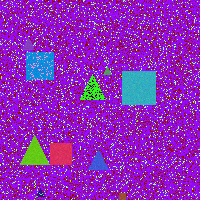

In [22]:
torchvision.transforms.ToPILImage()(generator[0]['image'])

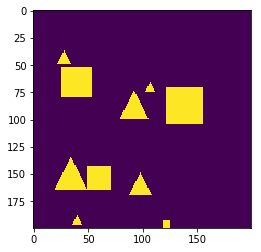

In [23]:
plt.imshow(np.array(generator[0]['mask'][0, :, :]).reshape((200, 200)))
plt.show()

Посчитаем среднее и дисперсию, чтобы дальше нормализовать с такими коэффициентами:

In [24]:
data = Figures(num_images=1000, noise=False)

image_pixels = torch.stack([ell['image'].reshape((3, -1)) for ell in data], dim=1)
mean_ = image_pixels.reshape((3, -1)).mean(1)
std_ = image_pixels.reshape((3, -1)).std(1)
normalize = torchvision.transforms.Normalize(mean_, std_)

### Обучение модели

Для оценки качества масок будем использовать Dice.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

При реализации не забывайте, что на вход поступает сразу весь батч, а результат должен быть усреднением dice-score по всем изображениям батча. Не забывайте о возможных численных неустойчивостях при возможности деления на ноль.

In [25]:
def dice_coefficient(mask, prediction):
    # your code
    numerator = 2 * torch.sum(torch.min(torch.cat((mask, prediction), dim=1), dim=1)[0], dim=(1,2))
    denominator = torch.sum(mask, dim=(2,3)).reshape(-1) + torch.sum(prediction, dim=(2,3)).reshape(-1)
    return torch.mean(torch.div(numerator,denominator))

Проверим реализацию dice.

In [26]:
torch.manual_seed(10)

test_mask = torch.randint(0, 2, size=(8, 1, 300, 300)).float()
prediction_mask = torch.randint(0, 2, size=(8, 1, 300, 300)).float()

dice_coefficient(test_mask, prediction_mask)

tensor(0.5005)

**Вопрос 3: Dice Coefficient**

Какой результат получился в клетке выше (ответ округлите до **четырех** знаков после запятой, например: 0.6576)? Внесите свой ответ в поле _"Вопрос 3: Dice Coefficient"_ гугл-формы этого домашнего задания.

In [27]:
0.5005

0.5005

Подготовим обучающую и тестовую выборки.

In [28]:
batch_size = 8

train_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=500),
    batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=200),
    batch_size=batch_size)

train_size = len(train_data_loader.dataset)
test_size = len(test_data_loader.dataset)

/Users/konstantinivanov/env_dmia_dl/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/Users/konstantinivanov/env_dmia_dl/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


Для обучения моделей необходимо определить функцию потерь, их примеры содержатся в модуле `torch.nn`. Сейчас для задачи бинарной сегментации нам потребуется бинарная кросс энтропия, которая на вход будет принимать не вероятности, а сырые значения (у нас сеть заканчивается линейным слоем). Найдите такую функцию.

In [29]:
criterion =  torch.nn.BCEWithLogitsLoss()
num_epoch = 10

network = UNet(num_classes=1)
optimizer = torch.optim.Adam(network.parameters())

In [30]:
global_step = 0

for epoch in range(num_epoch):
    loss_train = 0
    for i, batch in enumerate(train_data_loader):
        # main train loop: zero gradient, forward, loss, backward, update
        optimizer.zero_grad()
        output = network(batch['image'])
        loss = criterion(output, batch['mask'])
        loss_train += batch_size * float(loss.detach())
        loss.backward()
        optimizer.step()
    loss_train = loss_train / train_size
        
    loss_test, dice_test = 0, 0
    for i, batch in enumerate(test_data_loader):
        output = network(batch['image'])
        prediction_mask = (output > 0).float()
        loss_test += batch_size * float(criterion(output, batch['mask']).detach())
        dice_test += batch_size * float(dice_coefficient(batch['mask'], prediction_mask).detach())
    loss_test = loss_test / test_size
    dice_test = dice_test / test_size
    
    print('epoch: {},\ttrain loss: {},\ttest loss: {},\ttest dice: {}'.format(
        epoch, round(loss_train, 5), round(loss_test, 5), round(dice_test, 5)))

epoch: 0,	train loss: 0.33091,	test loss: 0.19433,	test dice: 0.01731
epoch: 1,	train loss: 0.16939,	test loss: 0.14028,	test dice: 0.7619
epoch: 2,	train loss: 0.1262,	test loss: 0.11524,	test dice: 0.86211
epoch: 3,	train loss: 0.10437,	test loss: 0.09498,	test dice: 0.90177
epoch: 4,	train loss: 0.0903,	test loss: 0.08552,	test dice: 0.92122
epoch: 5,	train loss: 0.07687,	test loss: 0.06207,	test dice: 0.94252
epoch: 6,	train loss: 0.03152,	test loss: 0.0247,	test dice: 0.95739
epoch: 7,	train loss: 0.02237,	test loss: 0.02031,	test dice: 0.96546
epoch: 8,	train loss: 0.01678,	test loss: 0.01611,	test dice: 0.97287
epoch: 9,	train loss: 0.0144,	test loss: 0.01425,	test dice: 0.9768


**Вопрос 4: Функция потерь на тестовой выборке**

Какое значение функции потерь получилось после 10 эпох на тестовой выборке (ответ округлите до **двух** знаков после запятой, например: 0.65)? Внесите свой ответ в поле _"Вопрос 4: Функция потерь на тестовой выборке"_ гугл-формы этого домашнего задания.

In [31]:
0.01

0.01

Визуализируйте 3 произвольных картинки, их маски и предсказания сети.

In [67]:
picts = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=3),
    batch_size=3
)
picts = next(iter(picts))

/Users/konstantinivanov/env_dmia_dl/lib/python3.6/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/Users/konstantinivanov/env_dmia_dl/lib/python3.6/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


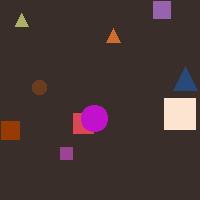

In [84]:
torchvision.transforms.ToPILImage()(picts['image'][0])

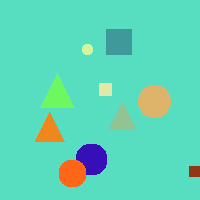

In [85]:
torchvision.transforms.ToPILImage()(picts['image'][1])

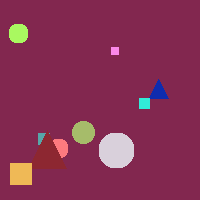

In [86]:
torchvision.transforms.ToPILImage()(picts['image'][2])

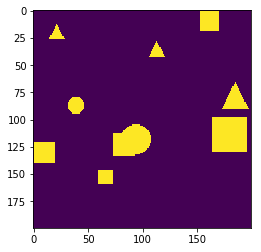

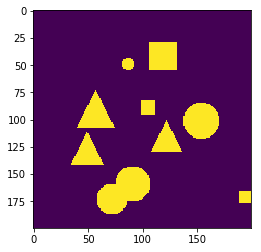

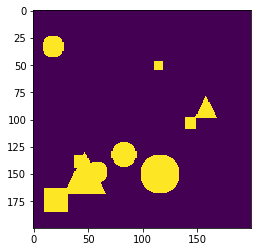

In [87]:
for pict in picts['mask']:
    plt.imshow(np.array(pict[0, :, :]).reshape((200, 200)))
    plt.show()

In [80]:
masks_predict = network(picts['image']).detach()

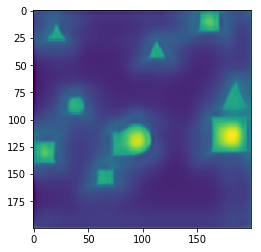

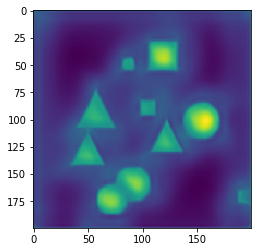

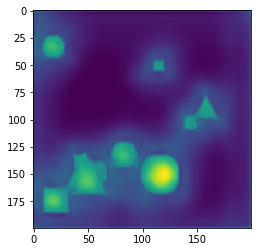

In [81]:
for mask in masks_predict:
    plt.imshow(np.array(mask[0, :, :]).reshape((200, 200)))
    plt.show()

Попробуйте увеличить `batch_size` в 4 раза и повторите обучение с теми же 10 эпохами.

In [94]:
batch_size = 8 * 4

train_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=1000),
    batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=250),
    batch_size=batch_size)

test_size = len(test_data_loader.dataset)

In [95]:
criterion = torch.nn.BCEWithLogitsLoss()
num_epoch = 10

network = UNet(num_classes=1)
optimizer = torch.optim.Adam(network.parameters())

In [96]:
global_step = 0

for epoch in range(num_epoch):
    loss_train = 0
    for i, batch in enumerate(train_data_loader):
        # main train loop: zero gradient, forward, loss, backward, update
        optimizer.zero_grad()
        output = network(batch['image'])
        loss = criterion(output, batch['mask'])
        loss_train += batch_size * float(loss.detach())
        loss.backward()
        optimizer.step()
    loss_train = loss_train / train_size
        
    loss_test, dice_test = 0, 0
    for i, batch in enumerate(test_data_loader):
        output = network(batch['image'])
        prediction_mask = (output > 0).float()
        loss_test += batch_size * float(criterion(output, batch['mask']).detach())
        dice_test += batch_size * float(dice_coefficient(batch['mask'], prediction_mask).detach())
    loss_test = loss_test / test_size
    dice_test = dice_test / test_size
    
    print('epoch: {},\ttrain loss: {},\ttest loss: {},\ttest dice: {}'.format(
        epoch, round(loss_train, 5), round(loss_test, 5), round(dice_test, 5)))

epoch: 0,	train loss: 1.04259,	test loss: 0.23502,	test dice: 9e-05
epoch: 1,	train loss: 0.37206,	test loss: 0.15875,	test dice: 0.42191
epoch: 2,	train loss: 0.28223,	test loss: 0.12681,	test dice: 0.82742
epoch: 3,	train loss: 0.2284,	test loss: 0.10514,	test dice: 0.89613
epoch: 4,	train loss: 0.14906,	test loss: 0.04998,	test dice: 0.9316
epoch: 5,	train loss: 0.08169,	test loss: 0.03886,	test dice: 0.95729
epoch: 6,	train loss: 0.0616,	test loss: 0.03121,	test dice: 0.96955
epoch: 7,	train loss: 0.05225,	test loss: 0.02516,	test dice: 0.98115
epoch: 8,	train loss: 0.04056,	test loss: 0.02192,	test dice: 0.98845
epoch: 9,	train loss: 0.03365,	test loss: 0.02074,	test dice: 0.99332


**Вопрос 5: Dice Coefficient на тестовой выборке**

Какое значение dice на тестовой выборке после 10 эпох (ответ округлите до **двух** знаков после запятой, например: 0.65)? Внесите свой ответ в поле _"Вопрос 5: Dice Coefficient на тестовой выборке"_ гугл-формы этого домашнего задания.

In [2]:
0.99

0.99